# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

GASS_data_path = gaskap_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

# Fcn

In [ ]:
see GALAH DR4 https://arxiv.org/pdf/2409.19858 Section 7.2.2
vlsr_sun = 15.17 # km/s


# Create velocity range around the central velocity
velocity_range = np.linspace(-100., 100., 500)

# Define the Gaussian function
def gaussian(x, amp, center, std):
    return amp * np.exp(-(x - center)**2 / (2 * std**2))

In [ ]:
def wavelength_to_rv(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity from observed and rest wavelengths using the
    relativistic Doppler formula.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    # Convert wavelengths to float if they're strings
    wavelength_obs = np.float64(wavelength_obs)
    wavelength_rest = np.float64(wavelength_rest)

    # Calculate velocity using relativistic formula
    c = const.c.to('km/s').value  # speed of light in km/s

    # (λ_obs / λ_rest)^2 = (1 + v/c)/(1 - v/c)
    # Solving for v:
    z = wavelength_obs / wavelength_rest
    rv = c * (z**2 - 1) / (z**2 + 1)

    return rv

def wavelength_to_rv_simple(wavelength_obs, wavelength_rest):
    """
    Calculate radial velocity using the simple (non-relativistic) Doppler formula.
    Use this only for v << c.

    Parameters:
    -----------
    wavelength_obs : float or array-like
        Observed wavelength(s) in Angstroms
    wavelength_rest : float
        Rest wavelength in Angstroms

    Returns:
    --------
    float or array-like
        Radial velocity in km/s (positive values indicate redshift/receding motion)
    """
    c = const.c.to('km/s').value  # speed of light in km/s

    # Simple Doppler formula: v/c = Δλ/λ
    # rv = c * (wavelength_obs - wavelength_rest) / wavelength_rest
    rv = c * (wavelength_obs - wavelength_rest) / wavelength_obs

    return rv

In [ ]:
def wavelength_to_vlsrk(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1 - rest_wavelength / observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk

In [ ]:
def wavelength_to_vlsrk_with_galah_correction(observed_wavelengths, rest_wavelength, galactic_l, galactic_b, rv_comp_1, u_lsr=11.1, v_lsr=12.24, w_lsr=7.25):
    """
    Converts observed wavelengths to VLSRK (velocity relative to the LSR) using the radio convention.

    Args:
        observed_wavelengths (array-like): Array of observed wavelengths (in Angstroms or nanometers).
        rest_wavelength (float): Rest wavelength of the spectral line (in the same units as observed_wavelengths).
        galactic_l (float): Galactic longitude (in degrees).
        galactic_b (float): Galactic latitude (in degrees).
        galah_allstar['rv_comp_1']: See GALAH
        u_lsr (float, optional): LSR velocity component towards the Galactic Center (km/s).
        v_lsr (float, optional): LSR velocity component in the direction of Galactic rotation (km/s).
        w_lsr (float, optional): LSR velocity component perpendicular to the Galactic plane (km/s).

    Returns:
        numpy.ndarray: Array of VLSRK velocities (in km/s).
    """

    c = const.c.to('km/s').value  # Speed of light in km/s

    observed_wavelengths = np.array(observed_wavelengths)

    # 1. Radial Velocity (Vrad) using radio convention
    vrad = c * (1. - rest_wavelength / observed_wavelengths) + rv_comp_1
    # vrad = c * (1. - rest_wavelength/observed_wavelengths)

    # 2. Heliocentric Velocity (Vhelio)
    # This requires more information about the observation time and location,
    # and the earth's velocity. For simplicity, we are skipping this part.
    # In practice, you would use astropy.coordinates.EarthLocation and astropy.time.Time,
    # to accurately get the earth's velocity.
    # For now, we are assuming Vhelio = Vrad. Therefore, the result will be slightly off.
    # vhelio = vrad

    # 3. VLSRK
    l_rad = np.radians(galactic_l)
    b_rad = np.radians(galactic_b)

    # vlsrk = vhelio + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)
    vlsrk = vrad + u_lsr * np.cos(b_rad) * np.cos(l_rad) + v_lsr * np.cos(b_rad) * np.sin(l_rad) + w_lsr * np.sin(b_rad)

    return vlsrk

In [ ]:
def binned_avg(x: np.ndarray, y: np.ndarray, bin_edges: np.ndarray, n_resamples = 1000):
    from scipy import stats

    # Calculate the bin average using scipy
    bin_avg, _, _ = stats.binned_statistic(x, y, statistic='mean', bins=bin_edges)

    # Container for bin averages
    bin_avg_arr = []

    # Perform bootstrap resampling and calculate bin averages
    for _ in range(n_resamples):
        resample_indices = np.random.choice(len(y), size=len(y), replace=True)
        resample_y= y[resample_indices]
        bin_avg_resample, _, _ = stats.binned_statistic(x, resample_y, statistic='mean', bins=bin_edges)
        bin_avg_arr.append(bin_avg_resample)

    # Compute the upper and lower percentiles of the bin averages
    bin_avg_arr = np.array(bin_avg_arr)
    bin_mean_arr = np.mean(bin_avg_arr, axis=0)
    bin_avg_upper = np.percentile(bin_avg_arr, 97.5, axis=0) - bin_mean_arr + bin_avg
    bin_avg_lower = np.percentile(bin_avg_arr, 2.5, axis=0) - bin_mean_arr + bin_avg

    return bin_avg, bin_avg_upper, bin_avg_lower

In [ ]:
# Define the Gaussian function with FWHM
def gaussian(x, A, x0, FWHM):
    sigma = FWHM / 2.3548
    return A * np.exp(-(x-x0)**2 / (2*sigma**2))

In [ ]:
def compute_column_density_KI(W_lambda_angstrom):
    """
    Compute the column density for weak lines:

    \[
    W_{\lambda} = \frac{\pi e^2}{m_e c^2} f \lambda^2 N
    \]

    Where:

    - \( e \) is the electron charge
    - \( m_e \) is the electron mass
    - \( c \) is the speed of light
    - \( f \) is the oscillator strength of the transition
    - \( \lambda \) is the wavelength of the line

    """
    # f = 0.3393  # Oscillator strength
    f = 0.332 # Oscillator strength
    lambda_ = 7698.9643 * u.Angstrom  # Wavelength in Angstrom lambda_rest = 7698.9643 # Angstroms

    # Convert equivalent width from Angstrom to meters
    W_lambda_m = (W_lambda_angstrom * u.Angstrom).to(u.m)

    # Compute column density using the formula
    N = (W_lambda_m * const.m_e * const.c**2) / (np.pi * const.e.gauss**2 * f * lambda_.to(u.m)**2)

    return N.to(10**(10)/u.cm**2)  # This ensures the column density is returned in SI units (m^-2)

<>:5: SyntaxWarning: invalid escape sequence '\['
<>:5: SyntaxWarning: invalid escape sequence '\['
/tmp/ipython-input-2010699875.py:5: SyntaxWarning: invalid escape sequence '\['
  \[


# For plotting

In [ ]:

# Circle
def _circle(x, y, r):
    theta = np.linspace(0, 2*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_LMC = 279.
gb_LMC = -33.5
R_LMC = 5.

gl_SMC = 302.
gb_SMC = -44.5
R_SMC = 3.

LMC = dict(
    gl = gl_LMC,
    gb = gb_LMC,
    center = [gl_LMC, gb_LMC],
    glon_range = [270., 307.],
    glat_range = [-48., -25.],
    circ = _circle(gl_LMC, gb_LMC, R_LMC),
    name = 'Large Magellanic Cloud'
)


SMC = dict(
    gl = gl_SMC,
    gb = gb_SMC,
    center = [gl_SMC, gb_SMC],
    glon_range = [295., 315.],
    glat_range = [-50., -40.],
    circ = _circle(gl_SMC, gb_SMC, R_SMC),
    name = 'Small Magellanic Cloud'
)

# Approximate locations of LMC and SMC
SMC_xcirc, SMC_ycirc = SMC['circ']
LMC_xcirc, LMC_ycirc = LMC['circ']

# Circle
def hcircle(x, y, r):
    theta = np.linspace(1.365*np.pi, 1.55*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

# Circle
def vcircle(x, y, r):
    theta = np.linspace(1.73*np.pi, 1.87*np.pi, 100)
    return x + r*np.cos(theta), y + r*np.sin(theta)

gl_ch = 295.
gb_ch = 21.8
R_ch = 59.

gl_cv = 238.
gb_cv = -5.
R_cv = 57.


ch_xcirc, ch_ycirc = hcircle(gl_ch, gb_ch, R_ch)
cv_xcirc, cv_ycirc = vcircle(gl_cv, gb_cv, R_cv)

lmc_glon = [270., 308.]
lmc_glat = [-48.99, -26.45]

gl_boundary = np.array([297., 302., 305., 308., 305., 297., 298., 295., 292., 294., 285., 283.5, 271.5, 271., 288.5, 290., 295., 297.])
gb_boundary = np.array([-36., -35., -40., -42.5, -48.5, -46.2, -43., -38.25, -39.8, -44.5, -45.9, -40.8, -41.5, -29., -26.9, -32., -31., -36.])

# Read GASKAP-HI absorption measurements: Pilot II data (all)

In [ ]:
hi_abs_all_filename = gaskap_hires_data_path / 'absdr3' / 'gaskap_abs_spectra_dr3b.csv'
print(hi_abs_all_filename)

abs_df = pd.read_csv(hi_abs_all_filename)
nmes, _ = abs_df.shape
print(f'Number of all sources {nmes}')
abs_df.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/absdr3/gaskap_abs_spectra_dr3b.csv
Number of all sources 2714


,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
0,0,J005611-710706,SB30665_component_1a,14.047482,-71.118446,302.378462,-46.004698,A,519.130005,442.507996,...,4.215,33.869999,1.236612e+21,False,0.000923,M344-11,30665,30665,True,False
1,8,J011049-731427,SB30665_component_3a,17.707468,-73.240921,300.996592,-43.814386,A,457.480988,596.744995,...,5.350,54.860001,4.874624e+21,False,-0.000770,M344-11,30665,30665,True,False
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
3,10,J004048-714600,SB30665_component_4a,10.200474,-71.766489,304.115161,-45.337319,A,428.450012,463.325989,...,4.905,175.600006,4.498524e+20,False,0.000679,M344-11,30665,30665,True,False
4,11,J005732-741242,SB30665_component_5a,14.385728,-74.211897,302.365011,-42.909634,A,428.031006,461.653015,...,4.895,175.509995,5.650006e+20,False,0.000971,M344-11,30665,30665,True,False


In [ ]:
non_hiabs_df = abs_df[abs_df.mw_detection == False]
non_hiabs_df

,id,comp_name,component_id,ra,dec,glon,glat,rating,flux_peak,flux_int,...,semi_min_axis,pa,n_h,noise_flag,continuum_slope,field,all_sbids,sbid,mw_detection,saturated
2,9,J011056-731406,SB30665_component_3b,17.735945,-73.235151,300.984436,-43.819266,A,115.037003,208.171005,...,5.745,39.880001,4.874624e+21,False,-0.000363,M344-11,30665,30665,False,False
8,24,J004327-704135,SB30665_component_11a,10.863942,-70.693260,303.888848,-46.420157,B,215.136993,332.138000,...,5.895,131.210007,2.227711e+20,False,0.000643,M344-11,30665,30665,False,False
10,26,J013229-723956,SB30665_component_12a,23.123198,-72.665757,298.690805,-44.122841,B,138.602005,138.981995,...,4.800,127.029999,1.083733e+21,False,0.002100,M344-06,30665,30665,False,False
11,28,J002919-754018,SB30665_component_13a,7.330447,-75.671738,304.752927,-41.378221,B,185.477005,206.205994,...,4.860,7.050000,1.705849e+20,False,0.002592,M344-11,30665,30665,False,False
12,29,J002920-754008,SB30665_component_13b,7.334793,-75.668999,304.751919,-41.381065,B,70.438004,70.567001,...,4.735,156.479996,1.705849e+20,False,0.000732,M344-11,30665,30665,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2709,0,J045631-762533,SB38845_component_245a,74.132371,-76.425960,288.737278,-32.932020,C,18.582001,20.014000,...,4.195,40.980000,0.000000e+00,False,-0.001994,M000-02,"38509,38845",38845,False,False
2710,0,J045907-753153,SB38845_component_261a,74.779860,-75.531478,287.674258,-33.105855,C,17.294001,21.070000,...,4.570,51.529999,0.000000e+00,False,-0.000745,M000-02,"38758,38845",38845,False,False
2711,0,J045340-751015,SB38758_component_264a,73.419855,-75.170876,287.418567,-33.556039,C,15.995000,17.537001,...,4.195,57.150002,0.000000e+00,False,0.004325,M000-02,"38758,38845",38758,False,False
2712,0,J060302-715904,SB33047_component_273a,90.760142,-71.984682,282.615941,-29.427549,C,16.532000,17.809999,...,3.845,84.059998,0.000000e+00,False,-0.017450,M000-02,"33047,38845",33047,False,False


# Read GASKAP-HI absorption MW foreground: Pilot II data (detection)

In [ ]:
spectra_filename = gaskap_hires_result_path / 'result_table_dr3_integrated_properties.csv'
print(spectra_filename)
df_det = pd.read_csv(spectra_filename)
ndet, ncols = df_det.shape
print(f'Number of rows {ndet},\n Number of columns: {ncols}')
df_det.head(5)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/result_table_dr3_integrated_properties.csv
Number of rows 462,
 Number of columns: 45


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigRfactor,nhi,signhi,nhi_thin,signhi_thin,ncnm,tsky,flux_int,ra_hr,tau_noise_per_channel
0,J001424-733911,30665,J001424-733911-30665,3.601159,-73.653109,306.494335,-43.218047,0,A,184.315994,...,0.123268,2.730491,0.297817,2.646857,0.110566,2,3.555342,179.488998,0.240077,0.014621
1,J002144-741500,30665,J002144-741500-30665,5.433208,-74.249829,305.669096,-42.720187,0,B,122.134003,...,0.139190,3.164146,0.399856,3.152547,0.179060,2,3.561425,132.397995,0.362214,0.028466
2,J002223-742825,30665,J002223-742825-30665,5.597676,-74.473760,305.562542,-42.505801,0,B,103.077003,...,0.093871,2.909353,0.249468,2.823752,0.085782,2,3.561425,206.740997,0.373178,0.019057
3,J002248-734007,30665,J002248-734007-30665,5.700254,-73.668709,305.692177,-43.305728,0,B,49.626999,...,0.084394,3.155461,0.213848,2.971679,0.125477,1,3.564467,49.803001,0.380017,0.057622
4,J002335-735529,30665,J002335-735529-30665,5.895892,-73.924770,305.565463,-43.060758,0,B,62.061001,...,0.093914,2.635446,0.234640,2.824470,0.128897,1,3.567508,61.556000,0.393059,0.018767


In [ ]:
glon_det = df_det['glon'].values
glat_det = df_det['glat'].values

# Read GASKAP-HI absorption CNM components

In [ ]:
cnm_filename = data_path / 'hires_result_CNM_components_dr3.csv'
print(cnm_filename)
df_cnm = pd.read_csv(cnm_filename)
nrows, ncols = df_cnm.shape
print(f'Number of rows {nrows},\n Number of columns: {ncols}')
df_cnm.head(5)

/content/gdrive/MyDrive/Colab Notebooks/gaia/data/hires_result_CNM_components_dr3.csv
Number of rows 691,
 Number of columns: 39


,comp_name,sbid,uniq_name,ra,dec,glon,glat,in_bridge,rating,flux_peak,...,sigtbcnm,nhicnm_cpn,signhicnm_cpn,fcnm_cpn,sigfcnm_cpn,nhi_tot,signhi_tot,tsky,nhicnm_avg,signhicnm_avg
0,J005611-710706,30665,J005611-710706-30665,14.047482,-71.118446,302.378462,-46.004698,0,A,519.130005,...,0.492912,0.258148,0.017671,0.115614,0.009510,2.232849,0.101853,3.543176,0.246904,0.023536
1,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.528091,0.061311,0.191089,0.029765,2.763580,0.286976,3.573591,0.526199,0.077868
2,J011049-731427,30665,J011049-731427-30665,17.707468,-73.240921,300.996592,-43.814386,0,A,457.480988,...,1.093266,0.145281,0.054101,0.052570,0.020323,2.763580,0.286976,3.573591,0.144746,0.066422
3,J004048-714600,30665,J004048-714600-30665,10.200474,-71.766489,304.115161,-45.337319,0,A,428.450012,...,0.809774,1.038635,0.153567,0.348299,0.109031,2.982020,0.822799,3.564467,1.031687,0.194750
4,J005732-741242,30665,J005732-741242-30665,14.385728,-74.211897,302.365011,-42.909634,0,A,428.031006,...,0.643373,0.359050,0.038501,0.131218,0.015583,2.736283,0.139665,3.485386,0.356473,0.053406


In [ ]:
glon_cnm = df_cnm['glon'].values
glat_cnm = df_cnm['glat'].values

In [ ]:
vcencnm = df_cnm['cencnm'].values
vcencnm.shape

(691,)

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
galah0 = Table.read(allstar_file)
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
med_dist_lim = 30_000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -80.) & (glat < lmc_glat[1]) & (med_dist > 0.) & np.isfinite(galah0['age'])]

In [ ]:
galah_fg = galah0[(galah0['l'] > lmc_glon[0]) & (galah0['l'] < lmc_glon[1]-2) & (galah0['b'] > -47.) & (galah0['b'] < -27.5) & (galah0['r_med'] > 0.) & (np.log10(galah0['ew_k_is']) > -1.5) & (np.log10(galah0['ew_k_is']) < 0.4)]
galah_fg

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
# See 8.9 Bug of interstellar K velocity in Buder et al. (2025)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

In [ ]:
galah_df = pd.DataFrame(np.array(galah['sobject_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec', 'V_UVW','l','b','v_sun_projection','ki_vlsrk','l_flip','lambda_k_is','rv_k_is_radio','ki_v_lsr_radio']))
galah_df

,sobject_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,V_UVW,l,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio
0,140713004601361,4685221429109310080,b'galah_main',182,b'allstar',56851.773438,0.001042,-75.687943,-37.697868,307.113381,-41.019988,-7.069331,-104.650508,307.113381,7696.458320,-97.612949,-104.682280
1,140711003901371,4634293351884119040,b'galah_main',411,b'allstar',56849.777344,0.014375,-80.592613,-34.638008,305.515414,-36.276474,-7.123088,2.011176,305.515414,7699.198877,9.133986,2.010898
2,140811005001160,4689447883087062784,b'galah_main',76,b'allstar',56880.710938,0.016250,-73.391861,-3.506775,307.934743,-43.233826,-7.027888,-1.188739,307.934743,7699.114255,5.839036,-1.188853
3,140811005001171,4689462520335582592,b'galah_main',76,b'allstar',56880.710938,0.018292,-73.218887,-15.143014,307.998606,-43.400444,-7.024397,-6.399740,307.998606,7698.980342,0.624655,-6.399742
4,140711003901061,4631183662419506048,b'galah_main',411,b'allstar',56849.777344,0.033167,-81.445580,-55.094646,305.255114,-35.449999,-7.127760,3.817190,305.255114,7699.245377,10.944551,3.816791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22401,140711003901032,6352336620255046912,b'galah_main',411,b'allstar',56849.777344,359.947052,-80.983002,-7.744434,305.409765,-35.895384,-7.122000,1.230774,305.409765,7699.178807,8.352541,1.230541
22402,150828004701380,6353031550259896064,b'galah_main',321,b'allstar',57262.667969,359.958282,-78.948608,25.830523,306.039658,-37.866417,-7.108079,-186.897080,306.039658,7694.347142,-179.896888,-187.004966
22403,141104003301215,6379489613954820864,b'galah_main',133,b'allstar',56965.511719,359.960754,-74.590111,-30.124155,307.515543,-42.075811,-7.047230,8.193784,307.515543,7699.355704,15.240239,8.193009
22404,140711003901037,6352328000257170048,b'galah_main',411,b'allstar',56849.777344,359.961639,-81.128830,-54.155178,305.362962,-35.754562,-7.123348,5.670360,305.362962,7699.292855,12.793162,5.669814


In [ ]:
med_dist = np.array(galah['r_med'].data, dtype='float32')

field_ids = np.array(galah['field_id'].data, dtype='int16')
star_ids = np.array(galah['sobject_id'].data, dtype='int64')

ra = galah['ra'].data
dec = galah['dec'].data

ew_k_is = galah['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))
rv_k_is = galah['rv_k_is']

ebv = galah['ebv']

glon = galah['l'].data
glat = galah['b'].data

# For all HI absoprtion detections

In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_using_gaussfit_smaller_radii_0155.csv'
print(gaskap_galah_csv_file)

ggdf = pd.read_csv(gaskap_galah_csv_file)
print(ggdf.shape)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/gaskap_abs_galah_star_ki_ism_using_gaussfit_smaller_radii_0155.csv
(462, 21)


In [ ]:
current_ggdf = ggdf[ggdf['star_id'] > 0]

In [ ]:
print(100.*current_ggdf.shape[0]/ggdf.shape[0])

62.77056277056277


# For KI/HI abundance ratios R = 1.5 pc


In [ ]:
def calculate_equivalent_width(velocity, optical_depth):
    """
    Calculates the equivalent width of an absorption line given optical depth vs velocity.

    Args:
        velocity (np.ndarray): Array of velocities (e.g., in km/s).
        optical_depth (np.ndarray): Array of optical depths corresponding to each velocity.

    Returns:
        float: The equivalent width of the absorption line.
    """
    # Ensure arrays are numpy arrays
    velocity = np.asarray(velocity)
    optical_depth = np.asarray(optical_depth)

    # Calculate the integrand (1 - exp(-tau(v)))
    integrand = 1 - np.exp(-optical_depth)

    # Perform numerical integration using the trapezoidal rule
    equivalent_width = np.trapezoid(integrand, velocity)

    return equivalent_width
# print(f"The equivalent width is: {W} km/s")

In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_using_gaussfit_large_radii_024.csv'
print(gaskap_galah_csv_file)

ggdf2 = pd.read_csv(gaskap_galah_csv_file)
print(ggdf2.shape)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/gaskap_abs_galah_star_ki_ism_using_gaussfit_large_radii_024.csv
(462, 21)


In [ ]:
ggdfc2 = ggdf2[ggdf2['star_id'] > 0]
print(ggdfc2.shape)

print(100.*ggdfc2.shape[0]/ggdf2.shape[0])

(403, 21)
87.22943722943722


In [ ]:
ki_hi_nsrcs2 = ggdfc2.shape[0]
print('N matched LOS: ', ki_hi_nsrcs2)

ki_ews2 = np.zeros(ki_hi_nsrcs2)
N_ki_is2 = np.zeros(ki_hi_nsrcs2)

nhi_tots2 = np.zeros(ki_hi_nsrcs2)

cnm_taus2 = np.zeros(ki_hi_nsrcs2)
cnm_nhi_cpns2 = np.zeros(ki_hi_nsrcs2)
nhi_thins2 = np.zeros(ki_hi_nsrcs2)
fcnm_los2 = np.zeros(ki_hi_nsrcs2)
fcnm_cpns2 = np.zeros(ki_hi_nsrcs2)

nhicnm_los2 = np.zeros(ki_hi_nsrcs2)
hi_ew_los2 = np.zeros(ki_hi_nsrcs2)

for j, srci in enumerate(ggdfc2.src_name.values):
    # KI row
    ggdf_row = ggdfc2[ggdfc2.src_name == srci].iloc[0]
    df_det_row = df_det[df_det.comp_name == srci].iloc[0]
    srci_ki_ew = ggdf_row.ew_ki_ism
    ki_ews2[j] = srci_ki_ew
    N_ki_is2[j] = compute_column_density_KI(srci_ki_ew).value

    # GASKAP source
    srci_cnm_df_rows = df_cnm[df_cnm.comp_name == srci]
    gaskap_src = df_det[df_det.comp_name == srci].iloc[0]

    gaskap_src_name = gaskap_src.comp_name
    gaskap_field = gaskap_src.sbid

    nhi = gaskap_src.nhi
    sig_nhi = gaskap_src.signhi
    nhi_thin = gaskap_src.nhi_thin

    src_glon = gaskap_src.glon
    src_glat = gaskap_src.glat

    srci_cnm_vels = srci_cnm_df_rows.cencnm.values
    srci_cnm_vel_selected = ggdf_row.emt_min_vlsr

    srci_cnm_nhi_cpns = srci_cnm_df_rows.nhicnm_cpn.values
    srci_nhi_tot = srci_cnm_df_rows.nhi_tot.values
    srci_fcnm_cpn = srci_cnm_df_rows.fcnm_cpn.values

    cnm_id = np.argmin(np.abs(srci_cnm_vels - srci_cnm_vel_selected))

    srci_cnm_taus = srci_cnm_df_rows.taucnm.values
    cnm_taus2[j] = srci_cnm_taus[cnm_id]


    # HI data: Open and load the pickle file
    gaskap_src_file = gaskap_hires_result_path / ('sb'+str(gaskap_field)) / f'{gaskap_src_name}.pkl'


    with open(gaskap_src_file, 'rb') as f:
        gaskap_res_data = pickle.load(f)


    gaskap_em_closest_em_profile = gaskap_res_data['EM_profiles'][:, 0]
    gaskap_em_avg_em_profile = np.mean(gaskap_res_data['EM_profiles'], axis=1)
    peak_tbi = np.max(gaskap_em_avg_em_profile)
    peak_close_tbi = np.max(gaskap_em_closest_em_profile)

    vlsr_gaskap = gaskap_res_data['vlsr_gaskap']
    sigemt_gaskap = gaskap_res_data['sigemt']
    emt_gaskap = gaskap_res_data['emt']

    tau_profile = gaskap_res_data['tau']
    peak_taui = np.max(tau_profile)

    ncnm = gaskap_res_data['ncnm']
    hgtcnm = gaskap_res_data['hgtcnm']
    cencnm = gaskap_res_data['cencnm']
    widcnm = gaskap_res_data['widcnm']

    hi_ew = calculate_equivalent_width(vlsr_gaskap, tau_profile)


    cnm_taus2[j] = srci_cnm_taus[cnm_id]
    cnm_nhi_cpns2[j] = srci_cnm_nhi_cpns[cnm_id]
    fcnm_cpns2[j] = srci_fcnm_cpn[cnm_id]

    fcnm_los2[j] = df_det_row['fcnm']
    nhicnm_los2[j] = df_det_row['nhicnm']
    hi_ew_los2[j] = hi_ew

    nhi_tots2[j] = gaskap_src.nhi

N matched LOS:  403


In [ ]:
# HI and KI from Hobbs (1974)
N_ki_hobbs_10los = np.array([10., 7.6, 4.3, 0.44, 3.0, 0.14,  0.25, 2.5, 3.4, 6.9]) # 10^11 cm-2
N_hi_hobbs_10los = np.array([10., 12., 20.,  6.,  11.0, 1.75, 1.75, 12.5, 20., 5.])  # 10^20 cm-2

In [ ]:
statpr, statpp = stats.pearsonr(N_ki_is2, nhi_tots2)
statspr, statspp = stats.spearmanr(N_ki_is2, nhi_tots2)
print('nhi_tots2 vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhi_tots2 vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhi_tots2 vs nki: pearson coefficient, statistic = 0.3422701295822306 , p-value = 1.6158298397859345e-12
nhi_tots2 vs nki: spearman coefficient, statistic = 0.40379860767359543 , p-value = 3.086550436496784e-17


Pearson correlation coefficient: 0.3423
p-value: 0.0000


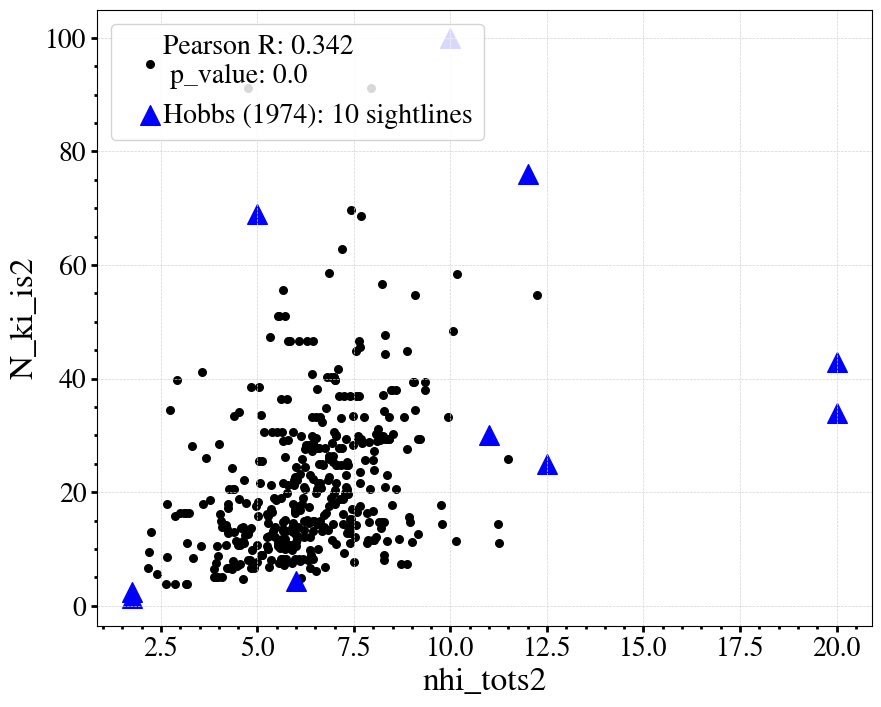

In [ ]:
xv = nhi_tots2
xv_lab = 'nhi_tots2'
yv = N_ki_is2
yv_lab = 'N_ki_is2'

# Calculate Pearson correlation coefficient
pearson_corr, p_value = stats.pearsonr(xv, yv)


print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
print(f"p-value: {p_value:.4f}")


# Plot
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)

ax.scatter(xv, yv, zorder=1, s=30, marker='o',
                 c='k',
                 label=f'Pearson R: {np.round(pearson_corr, 3)} \n p_value: {np.round(p_value, 3)}')

ax.scatter(N_hi_hobbs_10los, 10.*N_ki_hobbs_10los, zorder=1, s=200, marker='^',
                 c='b',
                 label=r'Hobbs (1974): 10 sightlines')



ax.set_xlabel(xv_lab, fontsize=24, fontweight='normal')
ax.set_ylabel(yv_lab, fontsize=24)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.legend(loc='upper left', fancybox=True, framealpha=0.85, labelcolor='k', fontsize=20, handletextpad=-0.5)


ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=1.8,
                    hspace=0.0
                    )

plt.show()

# For KI/HI abbundance ratios R = 0.75 pc

In [ ]:
ki_hi_nsrcs = current_ggdf.shape[0]
print('N matched LOS: ', ki_hi_nsrcs)

ki_amps = np.zeros(ki_hi_nsrcs)
ki_max_ress = np.zeros(ki_hi_nsrcs)
ki_ews = np.zeros(ki_hi_nsrcs)
N_ki_is = np.zeros(ki_hi_nsrcs)

peak_taus = np.zeros(ki_hi_nsrcs)
peak_fit_taus = np.zeros(ki_hi_nsrcs)

peak_tbs = np.zeros(ki_hi_nsrcs)
peak_close_tbs = np.zeros(ki_hi_nsrcs)

cnm_taus = np.zeros(ki_hi_nsrcs)
cnm_nhi_cpns = np.zeros(ki_hi_nsrcs)
nhi_tots = np.zeros(ki_hi_nsrcs)
nhi_thins = np.zeros(ki_hi_nsrcs)
fcnm_los = np.zeros(ki_hi_nsrcs)
fcnm_cpns = np.zeros(ki_hi_nsrcs)


nhicnm_los = np.zeros(ki_hi_nsrcs)
hi_ew_los = np.zeros(ki_hi_nsrcs)
hi_int_tau_los = np.zeros(ki_hi_nsrcs)
for j, srci in enumerate(current_ggdf.src_name.values):
    # KI row
    ggdf_row = current_ggdf[current_ggdf.src_name == srci].iloc[0]
    srci_ki_ew = ggdf_row.ew_ki_ism
    ki_ews[j] = srci_ki_ew
    N_ki_is[j] = compute_column_density_KI(srci_ki_ew).value

    df_det_row = df_det[df_det.comp_name == srci].iloc[0]

    # GASKAP source
    srci_cnm_df_rows = df_cnm[df_cnm.comp_name == srci]
    gaskap_src = df_det[df_det.comp_name == srci].iloc[0]

    gaskap_src_name = gaskap_src.comp_name
    gaskap_field = gaskap_src.sbid

    nhi = gaskap_src.nhi
    sig_nhi = gaskap_src.signhi
    nhi_thin = gaskap_src.nhi_thin

    src_glon = gaskap_src.glon
    src_glat = gaskap_src.glat

    srci_cnm_vels = srci_cnm_df_rows.cencnm.values
    srci_cnm_vel_selected = ggdf_row.emt_min_vlsr

    cnm_id = np.argmin(np.abs(srci_cnm_vels - srci_cnm_vel_selected))

    srci_cnm_taus = srci_cnm_df_rows.taucnm.values
    cnm_taus[j] = srci_cnm_taus[cnm_id]


    # HI data: Open and load the pickle file
    gaskap_src_file = gaskap_hires_result_path / ('sb'+str(gaskap_field)) / f'{gaskap_src_name}.pkl'


    with open(gaskap_src_file, 'rb') as f:
        gaskap_res_data = pickle.load(f)


    gaskap_em_closest_em_profile = gaskap_res_data['EM_profiles'][:, 0]
    gaskap_em_avg_em_profile = np.mean(gaskap_res_data['EM_profiles'], axis=1)
    peak_tbi = np.max(gaskap_em_avg_em_profile)
    peak_close_tbi = np.max(gaskap_em_closest_em_profile)

    vlsr_gaskap = gaskap_res_data['vlsr_gaskap']
    sigemt_gaskap = gaskap_res_data['sigemt']
    emt_gaskap = gaskap_res_data['emt']

    tau_profile = gaskap_res_data['tau']
    peak_taui = np.max(tau_profile)

    ncnm = gaskap_res_data['ncnm']
    hgtcnm = gaskap_res_data['hgtcnm']
    cencnm = gaskap_res_data['cencnm']
    widcnm = gaskap_res_data['widcnm']



    ki_max_ress[j] = ggdf_row.res_max_ki_ism
    ki_amps[j] = ggdf_row.amp_ki_ism
    ki_ews[j] = ggdf_row.ew_ki_ism

    peak_fit_taus[j] = peak_taui
    peak_taus[j] = gaskap_src.peak_tau

    peak_tbs[j] = peak_tbi
    peak_close_tbs[j] = peak_close_tbi

    nhi_tots[j] = gaskap_src.nhi
    nhi_thins[j] = gaskap_src.nhi_thin

    nhicnm_los[j] = df_det_row['nhicnm']
    hi_ew_los[j] = calculate_equivalent_width(vlsr_gaskap, tau_profile)
    hi_int_tau_los[j] = np.sum(tau_profile)*np.diff(vlsr_gaskap)[0]

N matched LOS:  290


In [ ]:
current_ggdf['peak_tau'] = peak_taus
current_ggdf['peak_fit_tau'] = peak_fit_taus
current_ggdf['peak_tb'] = peak_tbs
current_ggdf['peak_close_tb'] = peak_close_tbs

current_ggdf['nhi_tot'] = nhi_tots
current_ggdf['nhi_thin'] = nhi_thins

current_ggdf

In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_matched_los_smaller_radii_0155_extra_cols.csv'
print(gaskap_galah_csv_file)
current_ggdf.to_csv(gaskap_galah_csv_file, index=False)

# $N_\text{KI}$ vs CNM optical depth $\tau_\text{CNM}$

Pearson correlation coefficient: 0.2851
p-value: 0.0000007904


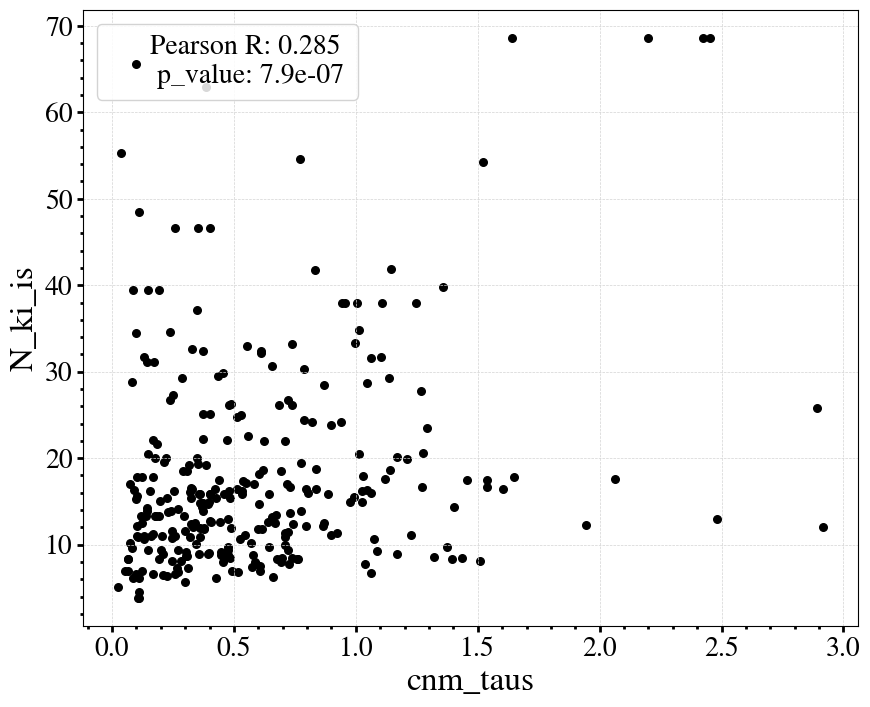

In [ ]:
xv = cnm_taus
xv_lab = 'cnm_taus'
yv = N_ki_is
yv_lab = 'N_ki_is'

# Calculate Pearson correlation coefficient
pearson_corr, p_value = stats.pearsonr(xv, yv)


print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
print(f"p-value: {p_value:.10f}")


# Plot
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)

ax.scatter(xv, yv, zorder=1, s=30, marker='o',
                 c='k',
                 label=f'Pearson R: {np.round(pearson_corr, 3)} \n p_value: {np.round(p_value, 8)}')

ax.set_xlabel(xv_lab, fontsize=24, fontweight='normal')
ax.set_ylabel(yv_lab, fontsize=24)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.legend(loc='upper left', fancybox=True, framealpha=0.85, labelcolor='k', fontsize=20, handletextpad=-0.5)




ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=1.8,
                    hspace=0.0
                    )

plt.show()

In [ ]:
statpr, statpp = stats.pearsonr(N_ki_is, cnm_taus)
statspr, statspp = stats.spearmanr(N_ki_is, cnm_taus)
print('cnm_taus vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('cnm_taus vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

cnm_taus vs nki: pearson coefficient, statistic = 0.28514327640760967 , p-value = 7.903709141810625e-07
cnm_taus vs nki: spearman coefficient, statistic = 0.22070928082596206 , p-value = 0.0001511682909015178


# $N_\text{KI}$ vs $N_\text{HI,CNM}$

Pearson correlation coefficient: 0.2722
p-value: 0.0000025465


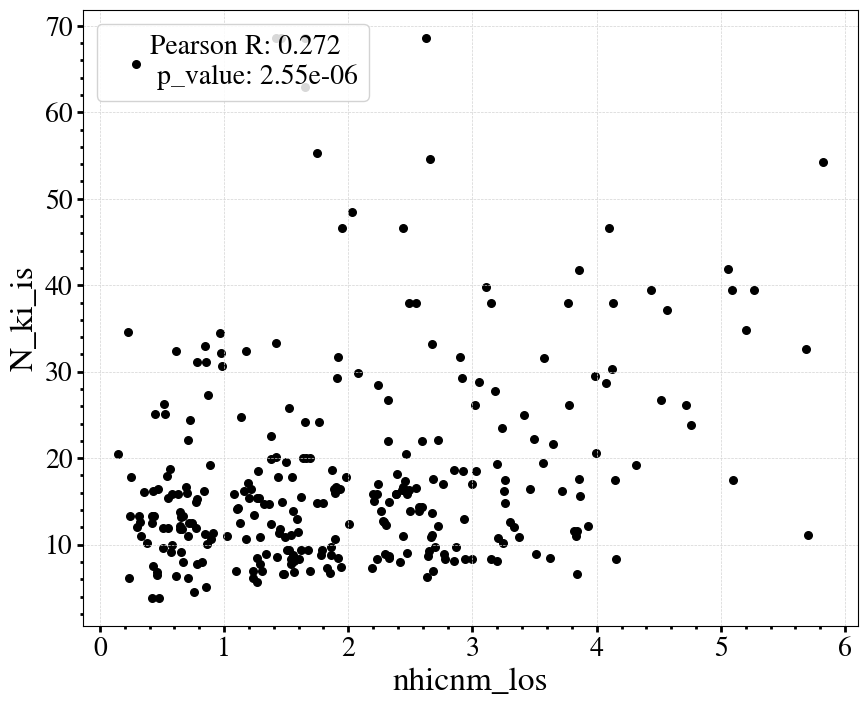

In [ ]:
xv = nhicnm_los
xv_lab = 'nhicnm_los'
yv = N_ki_is
yv_lab = 'N_ki_is'

# Calculate Pearson correlation coefficient
pearson_corr, p_value = stats.pearsonr(xv, yv)


print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
print(f"p-value: {p_value:.10f}")


# Plot
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)

ax.scatter(xv, yv, zorder=1, s=30, marker='o',
                 c='k',
                 label=f'Pearson R: {np.round(pearson_corr, 3)} \n p_value: {np.round(p_value, 8)}')

ax.set_xlabel(xv_lab, fontsize=24, fontweight='normal')
ax.set_ylabel(yv_lab, fontsize=24)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=20, pad=4)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.legend(loc='upper left', fancybox=True, framealpha=0.85, labelcolor='k', fontsize=20, handletextpad=-0.5)




ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=1.8,
                    hspace=0.0
                    )

plt.show()

In [ ]:
statpr, statpp = stats.pearsonr(N_ki_is, nhicnm_los)
statspr, statspp = stats.spearmanr(N_ki_is, nhicnm_los)
print('nhicnm_los vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhicnm_los vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhicnm_los vs nki: pearson coefficient, statistic = 0.2721924519146595 , p-value = 2.546466142376993e-06
nhicnm_los vs nki: spearman coefficient, statistic = 0.2500602134562817 , p-value = 1.6427165807250885e-05


# KI/CNM ratios $N_\text{KI}$ / $N_\text{HI,CNM}$

In [ ]:
ki_cnm_ratios = N_ki_is / nhicnm_los
ki_cnm_ratios.shape

(290,)

In [ ]:
print(np.min(ki_cnm_ratios), np.max(ki_cnm_ratios))

stats_series = pd.DataFrame(ki_cnm_ratios).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

1.7095498411579526 150.49732778231493


,0
count,290.000000
mean,13.777434
std,15.987230
min,1.709550
25%,5.414398
50%,8.470266
75%,15.399798
max,150.497328


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 1)
x_std = round(series_values[2], 1)
x_minval = round(series_values[3], 1)
x_maxval = round(series_values[-1], 1)
x_median = round(series_values[5], 1)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

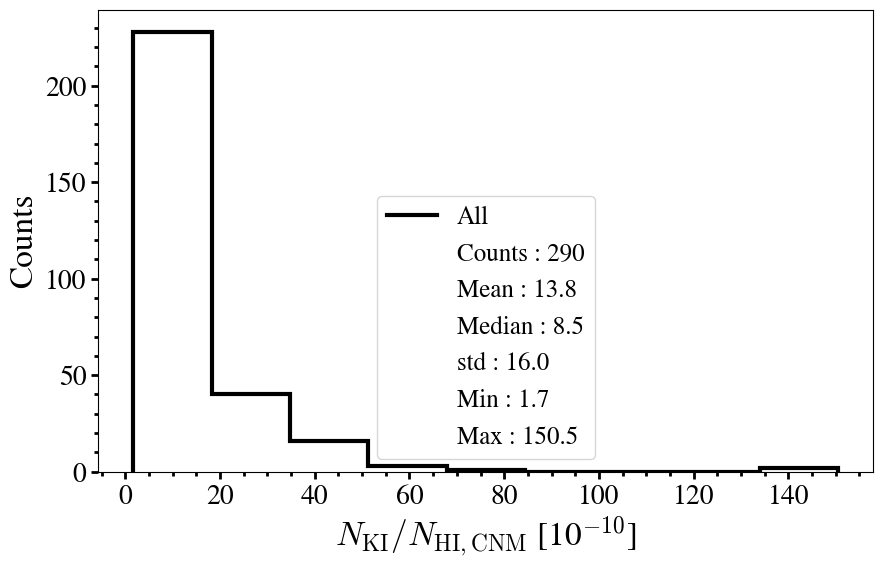

In [ ]:
from scipy import stats

plt.figure(figsize=(10, 6))

plt.hist(ki_cnm_ratios, bins=np.linspace(np.nanmin(ki_cnm_ratios), np.nanmax(ki_cnm_ratios), 10),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', linewidth=3,
         label='')

ploti, = plt.plot([], [], 'k-', lw=3, label=f'All')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'$N_\mathrm{KI} / N_\mathrm{HI,CNM}$ [10$^{-10}$]', fontsize=24)
plt.ylabel(r'Counts', fontsize=24)

plt.legend(loc='lower center', fontsize=18)
plt.show()

In [ ]:
statpr, statpp = stats.pearsonr(N_ki_is, hi_ew_los)
statspr, statspp = stats.spearmanr(N_ki_is, hi_ew_los)
print('hi_ew_los vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('hi_ew_los vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

hi_ew_los vs nki: pearson coefficient, statistic = 0.18692139024384335 , p-value = 0.0013855805721438282
hi_ew_los vs nki: spearman coefficient, statistic = 0.27354504349372993 , p-value = 2.259824279772418e-06


In [ ]:
# https://arxiv.org/pdf/2104.15013
NKI_Liszt = np.array([11.824, 12.000, 13.020,  11.428, 11.769])
NKI_Liszt = 10.**NKI_Liszt/1.e10
tau_int_Liszt = np.array([ 3.203, 10.927, 8.146,  0.938,  1.806])

In [ ]:
statpr, statpp = stats.pearsonr(N_ki_is, hi_int_tau_los)
statspr, statspp = stats.spearmanr(N_ki_is, hi_int_tau_los)
print('hi_int_tau_los vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('hi_int_tau_los vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

hi_int_tau_los vs nki: pearson coefficient, statistic = 0.25247356365760715 , p-value = 1.3514619379583205e-05
hi_int_tau_los vs nki: spearman coefficient, statistic = 0.2988157332326399 , p-value = 2.1528504797004457e-07


# KI column density

In [ ]:
# Table 1, here https://articles.adsabs.harvard.edu/pdf/1974ApJ...188L..67H
ew_ki_hobbs = np.array([108., 93., 111., 79., 65., 100., 7., 45., 2.3, 4., 8., 38., 51., 79., 39., 11., 142.]) # mili-Angstrom
N_ki_hobbs = np.array([7., 5.9, 10., 7.6, 4.3, 7.5, 0.44, 3.0, 0.14, 0.25, 0.47, 2.5, 3.4, 6.9, 2.5, 0.63, 11.]) # 10^11 cm-2

N_ki_hobbs_10los = np.array([10., 7.6, 4.3, 0.44, 3.0, 0.14,  0.25, 2.5, 3.4, 6.9]) # 10^11 cm-2
N_hi_hobbs_10los = np.array([10., 12., 20.,  6.,  11.0, 1.75, 1.75, 12.5, 20., 5.])  # 10^20 cm-2




gamma = 6.e-11  # s-1
alpha = 5.6e-12 # cm3 s-1
ne    = 0.06    # cm-3

In [ ]:
N_hobbs_ratio = (N_ki_hobbs_10los/ N_hi_hobbs_10los)
print('Mean, Median:', np.mean(N_hobbs_ratio), np.median(N_hobbs_ratio)) # ~0.5 e-9

Mean, Median: 0.41672510822510817 0.20750000000000002


In [ ]:
N_gg_ratio = N_ki_is/10. / nhi_thins
print('Mean, Median:', np.mean(N_gg_ratio), np.median(N_gg_ratio)) # ~0.5 e-9 Hobbs 1974

Mean, Median: 0.3016988346095758 0.24061315593522983


In [ ]:
N_gg_ratio = N_ki_is/10. / nhi_tots
print('Mean, Median:', np.mean(N_gg_ratio), np.median(N_gg_ratio)) # ~0.5 e-9 Hobbs 1974

Mean, Median: 0.2777675401453294 0.22871112830323242


In [ ]:
ki_abund_ratio_hobbs = 10.*N_ki_hobbs_10los / N_hi_hobbs_10los # in unit of 10^-10
np.mean(ki_abund_ratio_hobbs)

np.float64(4.167251082251083)

In [ ]:
xv = nhi_tots
xv_lab = r'$N_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]'
yv = N_ki_is
yv_lab = r'$N_\mathrm{KI}$ [10$^{10}$ cm$^{-2}$]'

# Calculate Pearson correlation coefficient
pearson_corr, p_value = stats.pearsonr(xv, yv)

In [ ]:
print(f"Pearson correlation coefficient: {pearson_corr}")
print(f"p-value: {p_value}")

Pearson correlation coefficient: 0.3552863133109447
p-value: 4.707365230094881e-10


In [ ]:
statpr, statpp = stats.pearsonr(xv, yv)
statspr, statspp = stats.spearmanr(xv, yv)
print('nhi vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhi vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhi vs nki: pearson coefficient, statistic = 0.3552863133109447 , p-value = 4.707365230094881e-10
nhi vs nki: spearman coefficient, statistic = 0.42543586768506053 , p-value = 3.5457846766988945e-14


In [ ]:
statpr, statpp = stats.pearsonr(N_ki_hobbs_10los, N_hi_hobbs_10los)
statspr, statspp = stats.spearmanr(N_ki_hobbs_10los, N_hi_hobbs_10los)
print('nhi vs nki: pearson coefficient, statistic =', statpr, ', p-value =', statpp)    # Pearson's r
print('nhi vs nki: spearman coefficient, statistic =', statspr, ', p-value =', statspp)    # spearmanr's r

nhi vs nki: pearson coefficient, statistic = 0.3106228948215168 , p-value = 0.3823655666941808
nhi vs nki: spearman coefficient, statistic = 0.4451302263229461 , p-value = 0.1973570541531603


In [ ]:
ki_abund_ratio_gg = yv/xv
print('GAGA mean: ', np.mean(ki_abund_ratio_gg))
print('GAGA median: ', np.median(ki_abund_ratio_gg))

GAGA mean:  2.777675401453294
GAGA median:  2.287111283032324


In [ ]:
ki_abund_ratio_hobbs = 10.*N_ki_hobbs_10los / N_hi_hobbs_10los # in unit of 10^-10
print('Hobbs 1974 mean: ', np.mean(ki_abund_ratio_hobbs))
print('Hobbs 1974 median: ', np.median(ki_abund_ratio_hobbs))

Hobbs 1974 mean:  4.167251082251083
Hobbs 1974 median:  2.075


Pearson correlation coefficient: 0.3553
p-value: 0.4845


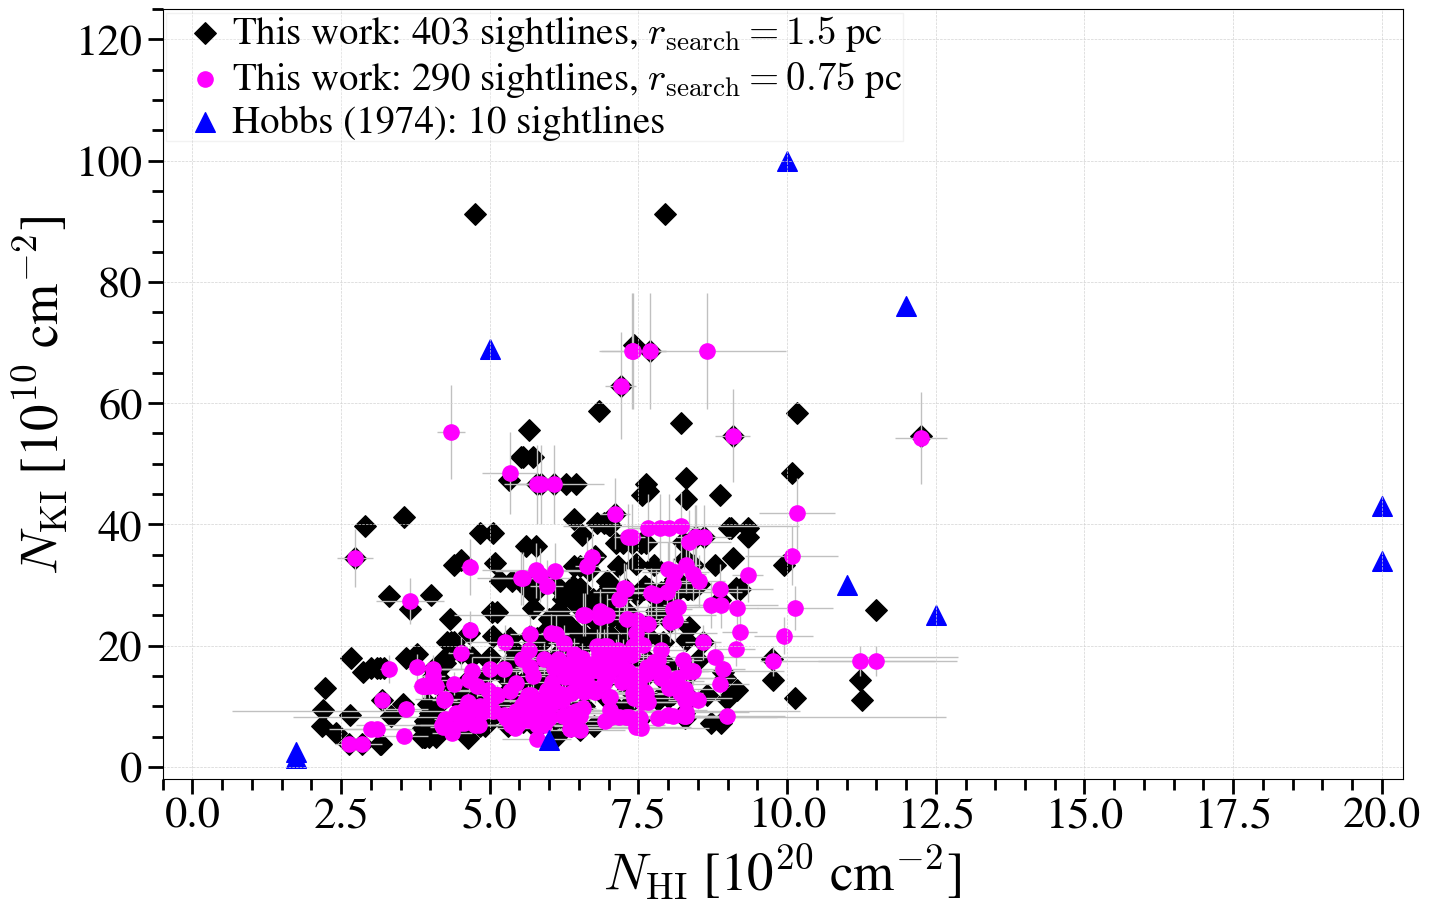

In [ ]:
print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
print(f"p-value: {p_value:.4f}")


# Plot
fig = plt.figure(figsize=(16,10))

ax = plt.subplot(111)

ax.errorbar(xv, yv,
             xerr=current_ggdf.sig_nhi.values, yerr=yv*0.14, zorder=0,
             ls='None', markersize=2,
             markeredgecolor='lightgrey', markeredgewidth=1,
             ecolor='silver', elinewidth=0.99,
             label='')

ax.scatter(nhi_tots2, N_ki_is2, zorder=-1, s=120, marker='D',
                 c='k',
                 label=r'This work: 403 sightlines, $r_\mathrm{search} = 1.5$ pc')


ax.scatter(xv, yv, zorder=1, s=120, marker='o',
                 c='magenta',
                 label=r'This work: 290 sightlines, $r_\mathrm{search} = 0.75$ pc')




ax.scatter(N_hi_hobbs_10los, 10.*N_ki_hobbs_10los, zorder=1, s=200, marker='^',
                 c='b',
                 label=r'Hobbs (1974): 10 sightlines')




ax.set_xlabel(xv_lab, fontsize=38, fontweight='normal')
ax.set_ylabel(yv_lab, fontsize=38)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=32, pad=2)
ax.tick_params(axis='y', labelsize=32)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=11)
ax.tick_params(which='minor', length=8)

ax.set_xlim(-0.5, 20.35)
ax.set_ylim(-2., 125)


ax.legend(bbox_to_anchor=(-0.007, 1.03, 1., -0.02), loc='upper left', fancybox=False, framealpha=0.25, labelcolor='k', fontsize=28, handletextpad=-0.3, borderpad=0.01, labelspacing=0.15, borderaxespad=0.3)




ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.,
                    hspace=0.0
                    )

plt.show()

In [ ]:
ki_abund_ratio_gg_403 = N_ki_is2/nhi_tots2
print('GAGA mean: ', np.mean(ki_abund_ratio_gg_403))
print('GAGA median: ', np.median(ki_abund_ratio_gg_403))

GAGA mean:  3.458252195031305
GAGA median:  3.0361925406838646


In [ ]:
x_hobbs = 10*N_hobbs_ratio
x_gg = 10*N_gg_ratio

# Perform the two-sample KS test
ks_statistic, p_value = stats.ks_2samp(x_hobbs, x_gg)

print(f"Kolmogorov-Smirnov Statistic: {ks_statistic}")
# print(f"P-value: {p_value:.4f}")
print(f"P-value: {p_value}")
print("-" * 30)

Kolmogorov-Smirnov Statistic: 0.25517241379310346
P-value: 0.48446266864999304
------------------------------


# End